# **Logistic and linear regression with deterministic and stochastic first order methods**

    Ecole Polytechnique | (Lab 2) : Optimisation - DataScience Master
    Authors : Alexandre Gramfort, Hicham Janati
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, even non-smooth ones, such as the $\ell_1$ penalization.

---

## **VERY IMPORTANT**

- This work **must be done by pairs of students**.
- **Each** student must send their work using the **moodle platform**, please
  check the deadline on moodle.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

--- 
### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "bryan"
ln1 = "chen"
fn2 = "alice"
ln2 = "devilder"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab2", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab2_chen_bryan_and_devilder_alice.ipynb


### **Gentle reminder: no evaluation if you don't respect this EXACTLY**

----

### **Table of content**

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

----

### **Import librairies and configuration**

In [2]:
%matplotlib inline

In [3]:
from time import time

import numba
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
from numba import njit

In [4]:
np.random.seed(42)

In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [6]:
# choose a large font size by default and use tex for math
usetex = False  # change this to True if you have a working LaTeX install

fontsize = 16
params = {
    "axes.labelsize": fontsize + 2,
    "font.size": fontsize + 2,
    "legend.fontsize": fontsize + 2,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "text.usetex": usetex,
}
plt.rcParams.update(params)

--- 
<a id='numba'></a>
## **0. Make sure Numba is correctly installed**
Instructions available at: http://numba.pydata.org/numba-doc/latest/user/installing.html

In [7]:
print(numba.__version__) # Your version of Numba

0.58.1


In [8]:
@njit
def go_fast(a): # Function is compiled to machine code when called the first time
    trace = 0.0
    # assuming square input matrix
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting

x = np.arange(100).reshape(10, 10)
x = x.astype(float)
go_fast(x) # Running a first time the function to compile it

array([[  9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.],
       [ 19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.],
       [ 29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.],
       [ 39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.],
       [ 49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.],
       [ 59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.],
       [ 69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.],
       [ 79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.],
       [ 89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.],
       [ 99., 100., 101., 102., 103., 104., 105., 106., 107., 108.]])

In [9]:
np.tanh(0)+ np.tanh(10) + np.tanh(20)

1.9999999958776926

Iteration time of the Numba-compiled function.

In [10]:
%timeit go_fast(x)

993 ns ± 26.4 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


Numba-compiled function have a special `.py_func` attribute which is the original uncompiled Python function.  Iteration time of the uncompiled function should be greater.

In [11]:
%timeit go_fast.py_func(x)

14.8 µs ± 894 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


----

<a id='loss'></a>
## **1. Loss functions, gradients and step-sizes**


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For each cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for least-squares regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [12]:
@njit    
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.

def loss_linreg(x, A, b, lbda):
    return np.linalg.norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * np.linalg.norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / n + lbda

In [13]:
@njit    
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

----

<a id='data'></a>
## **2. Generate a dataset**

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [14]:
from numpy.random import multivariate_normal, randn
from scipy.linalg import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [15]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [16]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

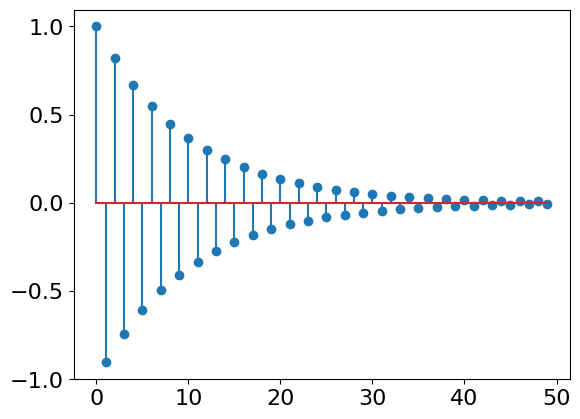

In [17]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [18]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

3.208966970469034e-06

In [19]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

1.1158071754505201e-07

### Choice of the model

In [20]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)

### Compute the theoretical step-size for gradient descent

In [21]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.06337638073416585


### Get a very precise minimum to compute distances to minimum

Here we use L-BFGS that you have not seen yet. Just take the estimated `x_min` and move on.
You will see L-BFGS later in the course.

In [22]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad,
                                args=(A, b, lbda), pgtol=1e-30, factr=1e-30)


print(f_min)
print(norm(grad_linreg(x_min, A, b, lbda)))

0.525869498235706
2.533335519814463e-08


--- 
<a id='batch'></a> 

## **3. Deterministic/Batch methods (GD, AGD)**

### Define a class to monitor iterations

In [23]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [24]:
# Number of iterations
n_iter = 200
# n_iter = 50

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the GD solver in the cell below

In [25]:
@njit
def gd(x_init, grad, n_iter=100, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x -= step * grad(x, *args)
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [26]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd_200 = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd_200.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipschitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the AGD solver in the cell below

In [27]:
@njit
def agd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        if i % store_every == 0:
            x_list.append(x.copy())
        ### TODO
        x_new = y - step * grad(y, *args)
        t_new = (1 + np.sqrt(1 + 4 * t ** 2)) / 2
        y = x_new + (t - 1) / t_new * (x_new - x)

        x = x_new
        t = t_new
    return x, x_list

In [28]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd_200 = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd_200.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [29]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("objective")
    plt.grid()
    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")
    plt.grid()
    plt.legend(solvers)
    

def plot_time(monitors, solvers, xscale='linear', yscale='log'):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")
        plt.yscale(yscale)
        plt.xscale(xscale)
    plt.grid()

    plt.legend(solvers)

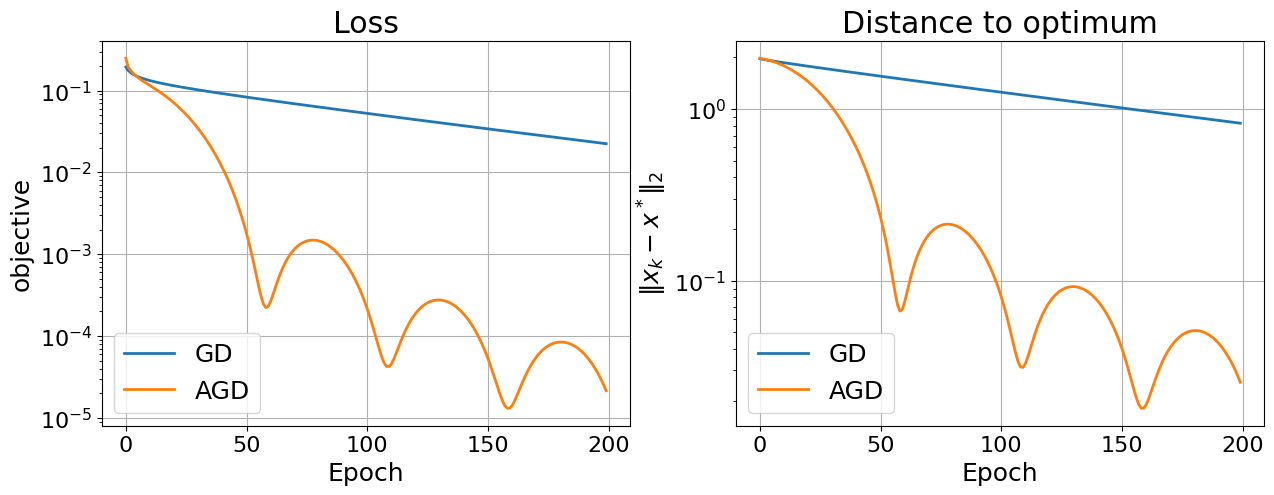

In [30]:
monitors = [monitor_gd_200, monitor_agd_200]

solvers = ["GD", "AGD"]

plot_epochs(monitors, solvers)

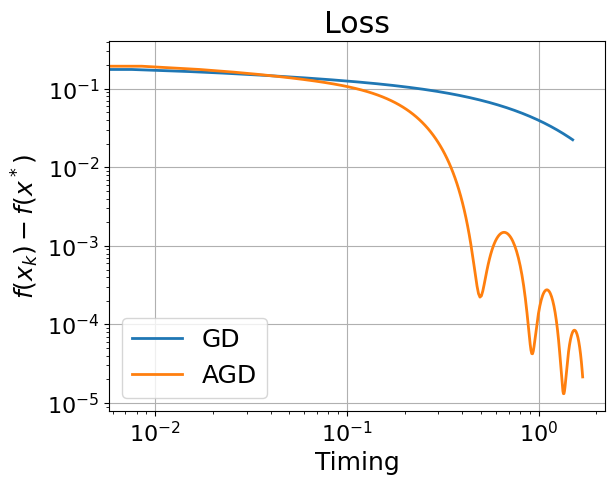

In [31]:
plot_time(monitors, solvers, xscale='log')

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here
- What do you observe about AGD? is it suprising ?

**Answers**:

Q1/ Concerning the loss plot, we can see that the loss decreases faster with AGD than with GD, which is expected since AGD is an accelerated version of GD. 

Indeed, the AGD algorithm has a $O(\frac{1}{k^2})$ convergence rate for $L$-smooth functions and a step size of $\frac{1}{L}$, whereas the GD algorithm has a $O(\frac{1}{k})$ convergence rate for $L$-smooth functions and a step size of $\rho \leq \frac{1}{L}$. You can find more details in the table below.

| Algorithm   |      Convergence Speed     |  Properties |
|----------|:-------------:|:------:|
| AGD | $O(\frac{1}{k^2})$ | $F(x^{(k)}) - F(x^{*}) \leq \frac{2L \lVert x^{(0)}-x^{*} \rVert}{k^2}$  |
| GD | $O(\frac{1}{k})$ | $F(x^{(k)}) - F(x^{*}) \leq \frac{\lVert x^{(0)}-x^{*} \rVert}{k} $  |

The same observation can be made for the distance to minimum plot. The distance to minimum decreases faster with AGD than with GD. We observe that there are some oscillations due to the acceleration of the algorithm (AGD) - the momentum term. 

Concerning the time plot, we can see that AGD is slower than GD in terms of computation time. Within one loop for each method, we have 2 more computations for AGD than for GD. 



Q2/ The fact that the AGD is slower than GD in terms of computation time may be surprising, because as the name suggests, AGD is an accelerated version of GD. However, the computation of the acceleration term in AGD may be more expensive than the computation of the gradient in GD. This could explain why AGD is slower than GD in terms of computation time.

----

<a id='stoc'></a> 
## **4. Stochastic methods**

In [32]:
n_iter = 50

# generate indices of random samples
random_indices = np.random.randint(0, n, n * n_iter)

In [33]:
print(random_indices)
print(random_indices.shape)

[6212 3182  971 ... 5436 4126 1579]
(500000,)


### **Implement the SGD solver**

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [34]:
@njit
def sgd(x_init, random_indices, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        i = random_indices[idx]
        
        ### TODO
        x -= step * grad_i(i, x, *args) / (np.sqrt(idx+1))
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [35]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd_50 = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd_50.run(x_init, random_indices, grad_i, n_iter * n, step0, args=(A, b, lbda))

### **BONUS: Implement the SGD with Averaging (SGDA) solver**

We recall that an iteration of SGDA writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$
- Apply if $t \geq s_0$ then : 
$$ \bar{\mathbf{x}}_t = \frac{1}{t - s_0} \sum_{i=s_0}^{t} \mathbf{x}_{i} $$
- Else, apply : 
$$ \bar{\mathbf{x}}_t = \mathbf{x}_t$$

where $\eta_0$ is a step-size to be tuned by hand, and $s_0 \geq 0$ is the number of iterations before starting averaging.

<!-- 1. Initialize $ \mathbf{x}^{(0)} $, set $ s_0 \geq 0 $ -->
<!-- 2. For $ k = 0, 1, 2, \dots $ do -->
<!-- 3. &nbsp;&nbsp;&nbsp;&nbsp; $ i^{(k)} \leftarrow $ randomly pick an index $ i \in \{1, \dots, n\} $ -->
<!-- 4. $ \mathbf{d}^{(k)} \leftarrow - \nabla_{\mathbf{x}} f_{i^{(k)}}(\mathbf{x}^{(k)}) $
5. $ \mathbf{x}^{(k+1)} \leftarrow \mathbf{x}^{(k)} + \rho^{(k)} \mathbf{d}^{(k)} $
6. If $ k \geq s_0 $ then
7. $ \bar{\mathbf{x}}^{(k)} = \frac{1}{k - s_0} \sum_{i=s_0}^{k} \mathbf{x}^{(i)} $
8. Else
    9. $ \bar{\mathbf{x}}^{(k)} = \mathbf{x}^{(k)} $
10. End if
11. End for -->


In [36]:
@njit
def sgda(x_init, random_indices, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent with averaging algorithm."""
    
    s0 = int(n_iter / 2) 
    x = x_init.copy() 
    x_list = []  
    avg_x = np.zeros_like(x) 
    
    for idx in range(n_iter):
        i = random_indices[idx]  
        grad = grad_i(i, x, *args)  
        x -= step * grad / np.sqrt(idx + 1)

        if idx >= s0:
            avg_x = (avg_x * (idx - s0) + x) / (idx - s0 + 1)

        if idx % store_every == 0:
            if idx >= s0:
                x_list.append(avg_x.copy())
            else:
                x_list.append(x.copy())
    
    return avg_x if n_iter > s0 else x, x_list

In [37]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgda_50 = monitor(sgda, loss, x_min, (A, b ,lbda))
monitor_sgda_50.run(x_init, random_indices, grad_i, n_iter * n, step0, args=(A, b, lbda))

### **Comparison SGD and SGDA**

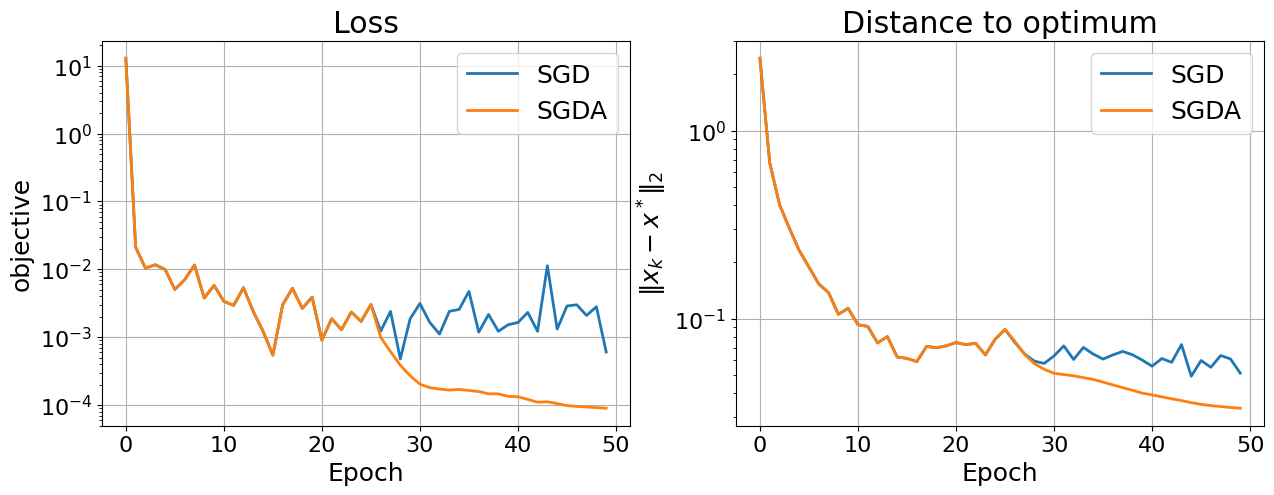

In [38]:
monitors = [monitor_sgd_50, monitor_sgda_50]

solvers = ["SGD", "SGDA"]

plot_epochs(monitors, solvers)

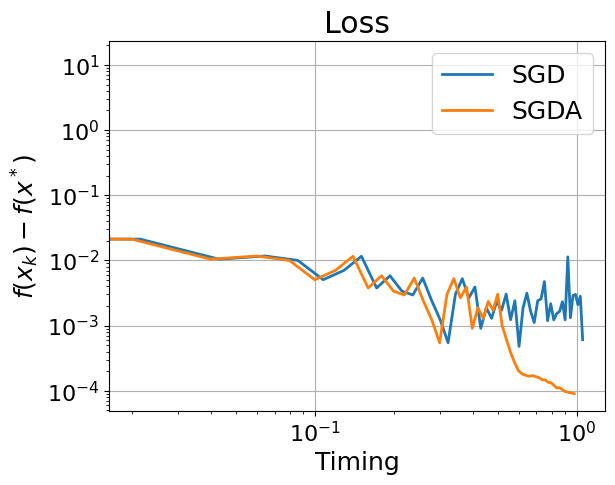

In [39]:
plot_time(monitors, solvers, xscale='log')

**Comments:** We observe that SGDA is smoother than SGD after some iterations because the algorithm SGDA starts to average the iterates after `s0` iterations. This averaging step allows to reduce the variance of the iterates and thus to have a smoother convergence. Moreover, the loss is lower (and the distance to the optimum as well) with SGDA than with SGD, thus better in terms of performance.

----

### **Implement the SAG solver**

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [40]:
@njit
def sag(x_init, random_indices, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d)) #g_i^t
    averaged_gradient = np.zeros(d) #G_t
    x_list = []
    for idx in range(n_iter):
        i = random_indices[idx]
        
        ### TODO
        averaged_gradient = np.sum(gradient_memory, axis=0) / n
        gradient_memory[i] = grad_i(i, x, *args)

        x -= step * averaged_gradient
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [41]:
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)
monitor_sag_50 = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag_50.run(x_init, random_indices, grad_i, n_iter * n, step, args=(A, b, lbda))

### **BONUS: Implement the SAGA solver**

We recall that an iteration of SAGA writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the direction

$$d_t = \nabla_x f_{i_t}(x_t) - g_{i_t} + G_t$$
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$



3. Apply the step 
$$x_{t+1} \gets x_t - \rho d_t$$
where $\rho$ is the step-size.

4. Apply the proximal operator
$$x_{t+1} \gets \text{prox}_{\rho \frac{\lambda}{2} \|\cdot\|_2^2}(x_{t+1})$$

*QUESTION*:
- Fill in the iteration of the SAGA solver in the cell below

In [42]:
@njit
def prox_L2(x, step):
        """Proximal operator for the L2 penalty."""
        return x / (1 + step)

In [58]:
@njit
def saga(x_init, random_indices, grad_i, n_iter=100, step=1., store_every=n, args=()):
    
    """SAGA algorithm."""
    x = x_init.copy()
    gradient_memory = np.zeros((n, d)) 
    averaged_gradient = np.zeros(d)
    x_list = []

    lbda = args[-1]

    for idx in range(n_iter):
        i = random_indices[idx]
        
        grad_i_value = grad_i(i, x, *args) 
        direction_k = grad_i_value - gradient_memory[i] + averaged_gradient
        x -= step * direction_k
        x = prox_L2(x, step * lbda) 

        averaged_gradient += (grad_i_value - gradient_memory[i])/n
        gradient_memory[i] = grad_i_value
        
        if idx % store_every == 0:
            x_list.append(x.copy())

    return x, x_list

In [55]:
lbda_saga = 1. / n ** 2
max_squared_sum_saga = np.max(np.sum(A ** 2, axis=1))
step_saga = 1.0 / (max_squared_sum_saga + lbda_saga)

x_init = np.zeros(d)
x_min_saga, f_min_saga, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda_saga), pgtol=1e-30, factr=1e-30)
monitor_saga_50 = monitor(saga, loss, x_min_saga, (A, b,lbda_saga))
monitor_saga_50.run(x_init, random_indices, grad_i, n_iter * n, step_saga, args=(A, b, lbda_saga))

### **Comparison SAG and SAGA**

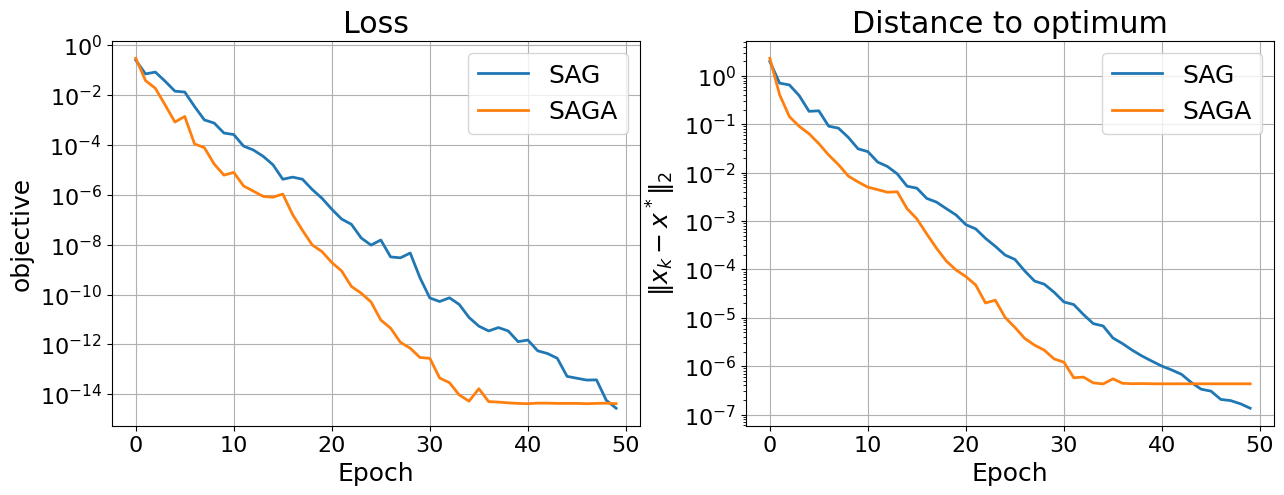

In [56]:
monitors = [monitor_sag_50, monitor_saga_50]

solvers = ["SAG", "SAGA"]

plot_epochs(monitors, solvers)

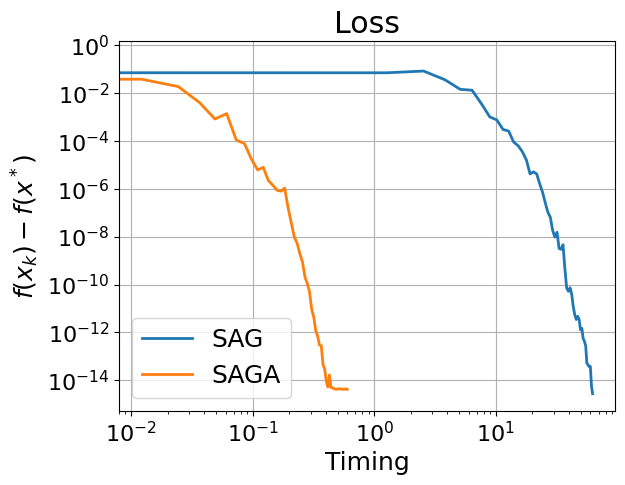

In [57]:
plot_time(monitors, solvers, xscale='log')

**Comments:** We observe surprisingly that using the same parameters, SAGA was slower than SAG in terms of convergence and worse in performance. Therefore, we decided to choose a really small lambda, leading to the proximal operator to be the identity function. Indeed, as $\text{prox}_{\rho \frac{\lambda}{2} \|\cdot\|_2^2}(x) = \frac{x}{1+\lambda \rho} \approx x$. We can see that SAGA is now faster than SAG in terms of convergence and better in performance.

-----

### **SVRG**

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [59]:
@njit
def svrg(x_init, random_indices, grad, grad_i, n_iter=100, step=1., store_every=1, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    x_list = []
    for idx in range(n_iter):
        
        ### TODO     
        mu_k = grad(x_old, *args)
        x = x_old.copy()
        
        for t in range(n):
            i = random_indices[t]
            gt = (grad_i(i, x, *args) - grad_i(i, x_old, *args) + mu_k)
            x -= step * gt
        
        x_old = x.copy()
        x = x_old

        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [60]:
x_init = np.zeros(d)
monitor_svrg_50 = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg_50.run(x_init, random_indices, grad, grad_i, n_iter, step, args=(A, b, lbda))

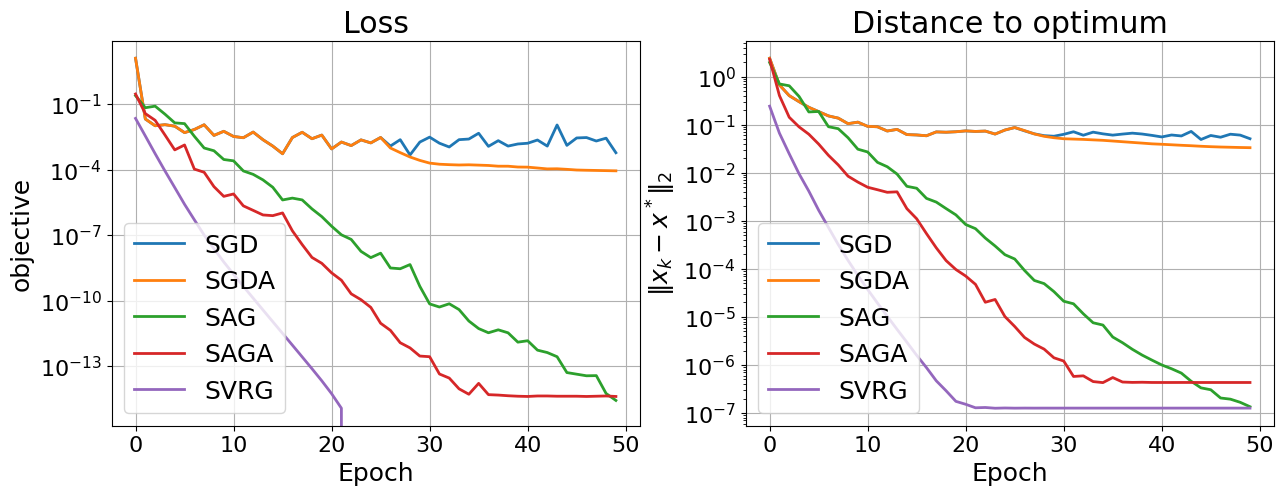

In [61]:
monitors = [monitor_sgd_50, monitor_sgda_50, monitor_sag_50, monitor_saga_50, monitor_svrg_50]
solvers = ["SGD", "SGDA", "SAG", "SAGA", "SVRG"]
plot_epochs(monitors, solvers)

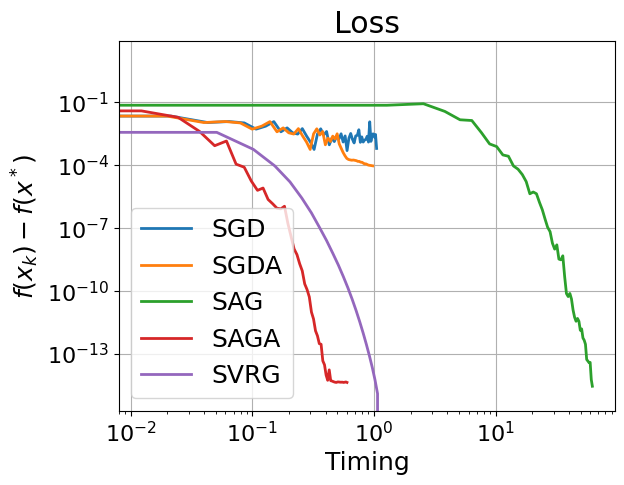

In [62]:
plot_time(monitors, solvers, xscale='log')

**Comments:** 

----

<a id='comp'></a> 
## **5. Numerical comparison**

In [63]:
# compute gd and agd with n_iter = 50
n_iter = 50
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd_50 = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd_50.run(x_init, grad, n_iter, step, args=(A, b, lbda))

x_init = np.zeros(d)
monitor_agd_50 = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd_50.run(x_init, grad, n_iter, step, args=(A, b, lbda))

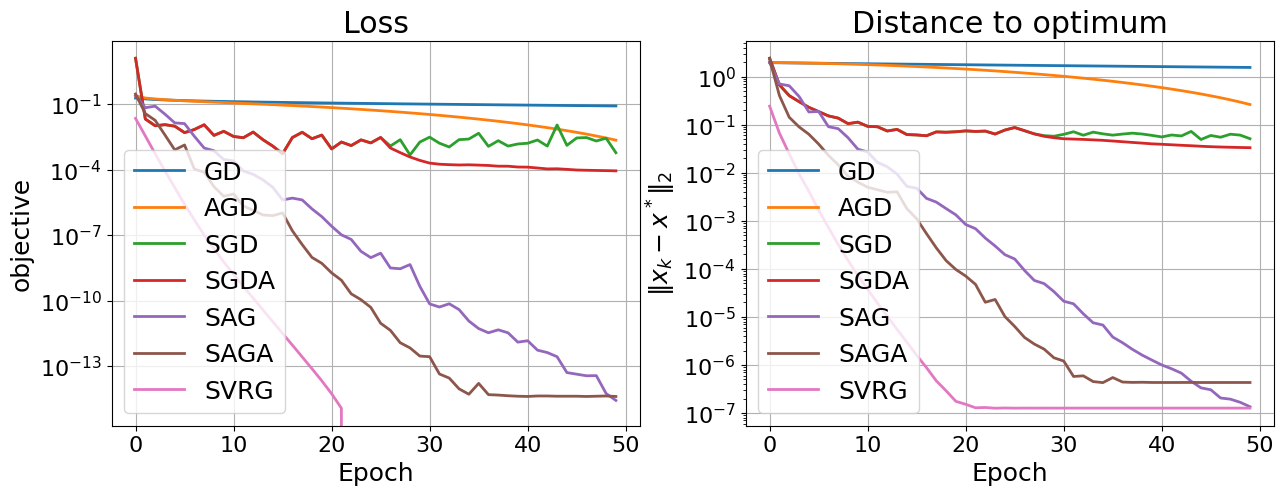

In [64]:
monitors = [monitor_gd_50, monitor_agd_50,
            monitor_sgd_50, monitor_sgda_50,
            monitor_sag_50, monitor_saga_50, 
            monitor_svrg_50]

solvers = ["GD", "AGD", "SGD", "SGDA", "SAG", "SAGA", "SVRG"]

plot_epochs(monitors, solvers)

**Comments:** We observe that SVRG is the fastest algorithm in terms of convergence and performance, followed by SAG. Indeed, both algorithms, for f strongly convex and L-smooth, have a exponential convergence rate

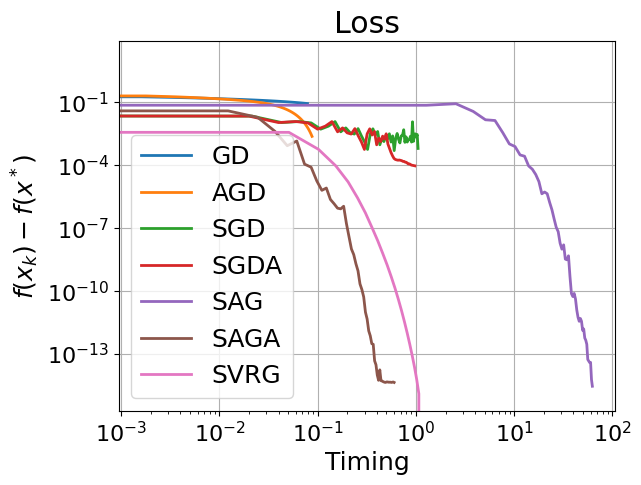

In [65]:
plot_time(monitors, solvers, xscale='log')

----
<a id='conc'></a>
## **6. Conclusion**

*QUESTIONS*:
- Q1/ Compare and comment your results
- Q2/ Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1$ and compare your results. Comment.
- Q3/ Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Q4/ Conclude

### **Question 1: Comparison and comments of the results**

Q1/

- Among all the algorithms we considered, `SVRG` is the fastest in terms of convergence and performance. Indeed, SVRG has an exponential convergence rate for f strongly convex and L-smooth. Concerning the computation time, SVRG is better than SGD, SAG and SAGA, but worse than deterministic methods (GD, AGD), which is intuitive since SVRG computes subgradients as SGD, SAG and SAGA but also computes the full gradient (but less than deterministic methods), which is more expensive, but allows to have a better convergence rate. 
- Similarly, `SAG` is also a good algorithm in terms of convergence and performance, not as good as SVRG, better than SGD, SGDA, because SAG uses an average of the gradients instead of a single one. `SAGA` is a variant of SAG that uses proximal operator and considers an acceleration term (momentum). Both have an exponential convergence rate for f strongly convex and L-smooth, SAGA has just a better constant than SAG since it uses the proximal operator (thus is an accelerated version of SAG), but still worse than SVRG with the same lambda. But, we observe that the computation time of SAG and SAGA is worse than deterministic methods (GD, AGD). 
- Concerning `SGD`, it is better than the deterministic methods (GD, AGD) in terms of convergence and performance, but worse in terms of computation time. We notice that `SGDA` is better than SGD in terms of performance, because it averages the iterates after `s0` iterations. SGD is better than deterministic methods insofar as it computes only one gradient at each iteration, whereas deterministic methods compute all the gradients at each iteration.
- The fastest algorithms in terms of computation time are the deterministic methods (GD, AGD) (because they don't need to compute the subgradients, which is less informative than the full gradient that they compute so they need less steps), followed by SVRG, SGD and SGDA, and finally SAG and SAGA. In contrast, the best algorithm in term of performance is SVRG, followed by SAGA, SAG, SGDA, SGD, AGD and GD.

### **Question 2: Influence of the value of the ridge regularization (low ridge and high ridge)**

In [ ]:
lbda_list = [1 / n, 1]
monitors_list_lbda = [[] for _ in lbda_list]
dict_algo_string = {gd: "GD", agd: "AGD", sgd: "SGD", sgda: "SGDA", sag: "SAG", saga: "SAGA", svrg: "SVRG"}

for i, lbda in enumerate(lbda_list):
    x_init = np.zeros(d)
    x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad,args=(A, b, lbda), pgtol=1e-30, factr=1e-30)

    for algo in dict_algo_string.keys():

        # GD and AGD
        if algo in [gd, agd]: 
            step = 1. / lipschitz_linreg(A, b, lbda)
            monitor_instance = monitor(algo, loss, x_min, (A, b, lbda))
            monitor_instance.run(x_init, grad, n_iter, step, args=(A, b, lbda))
            monitors_list_lbda[i].append(monitor_instance)
            
        # SGD et SGDA
        elif algo in [sgd, sgda]:
            step = 1e-1
            monitor_instance = monitor(algo, loss, x_min, (A, b, lbda))
            monitor_instance.run(x_init, random_indices, grad_i, n_iter * n, step, args=(A, b, lbda))
            monitors_list_lbda[i].append(monitor_instance)
            
        # SAG et SAGA
        elif algo in [sag, saga]:
            max_squared_sum = np.max(np.sum(A ** 2, axis=1))
            step = 1.0 / (max_squared_sum + lbda)
            monitor_instance = monitor(algo, loss, x_min, (A, b, lbda))
            monitor_instance.run(x_init, random_indices, grad_i, n_iter * n, step, args=(A, b, lbda))
            monitors_list_lbda[i].append(monitor_instance)
            
        # SVRG
        elif algo in [svrg]:
            max_squared_sum = np.max(np.sum(A ** 2, axis=1))
            step = 1.0 / (max_squared_sum + lbda)
            monitor_instance = monitor(svrg, loss, x_min, (A, b, lbda))
            monitor_instance.run(x_init, random_indices, grad, grad_i, n_iter, step, args=(A, b, lbda))
            monitors_list_lbda[i].append(monitor_instance)

Norm x_init - x-min = 2.313591544143446
Norm x_init - x-min = 0.23506264703930568


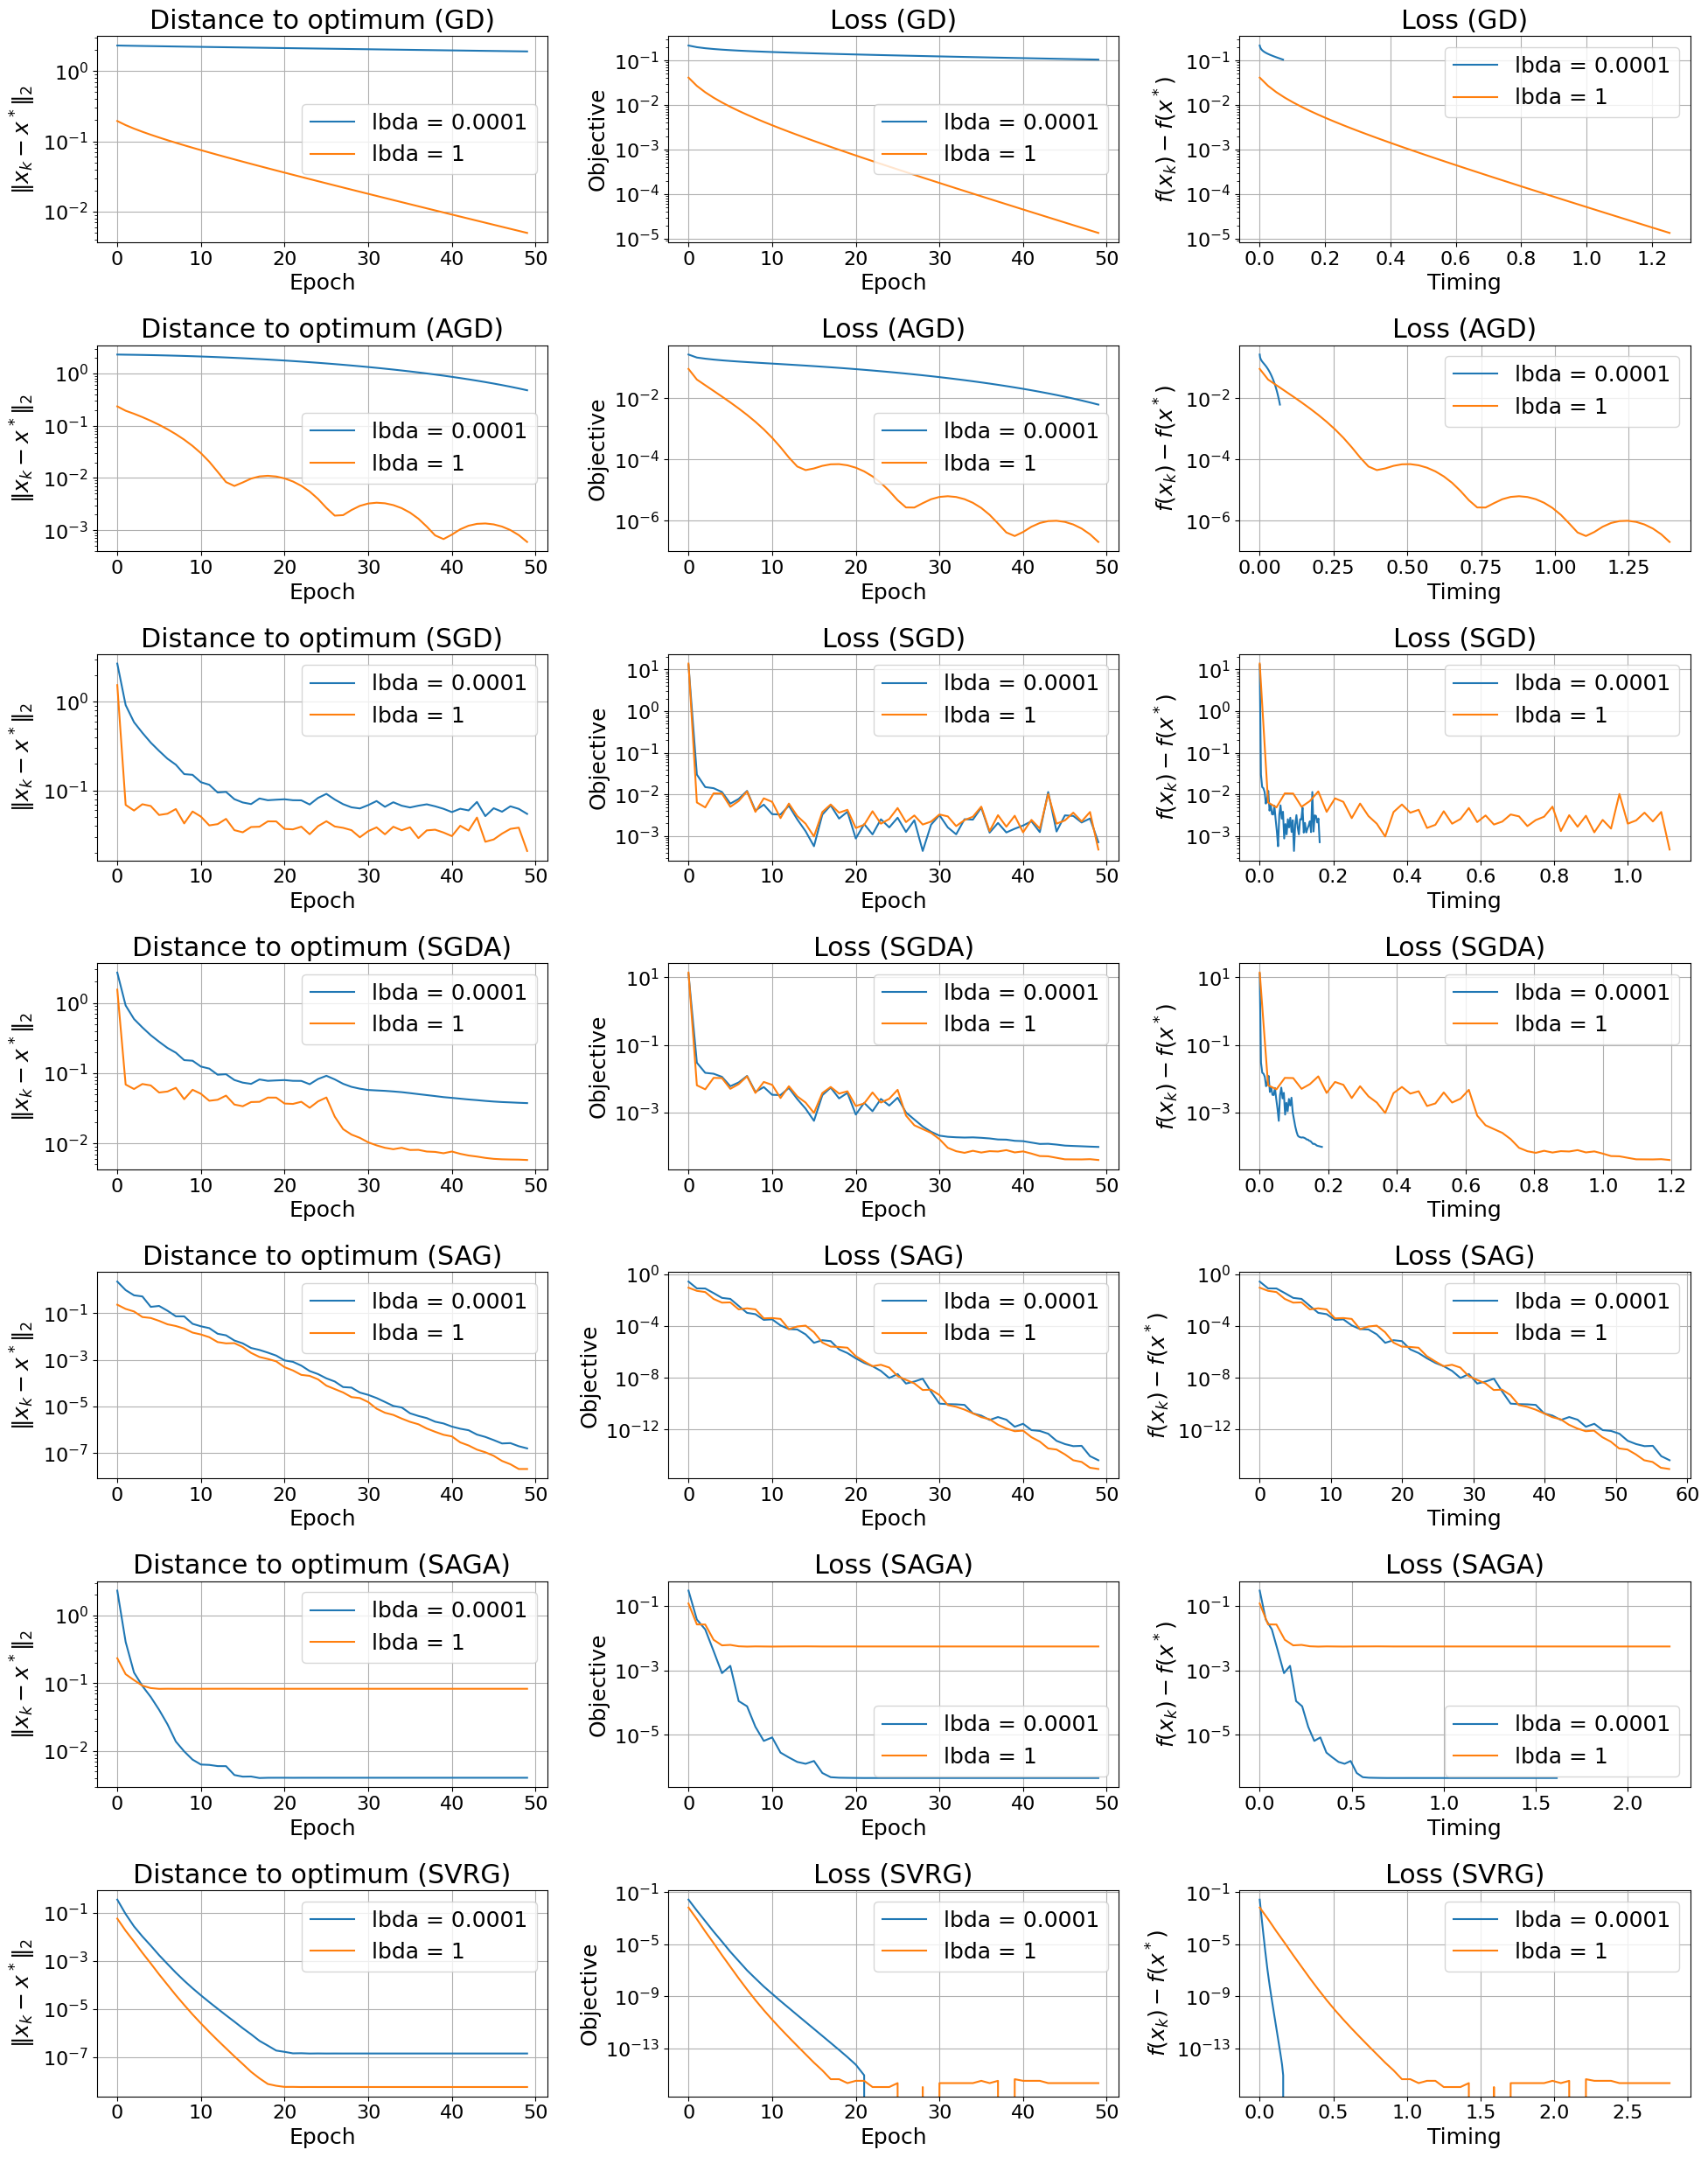

In [72]:
fig, axes = plt.subplots(7, 3, figsize=(20, 25))

# List of the keys of the dictionnary
keys_list = list(dict_algo_string.values())

for i, col_number in enumerate(np.array(monitors_list_lbda).squeeze().T):
    for j, monitor_instance in enumerate(col_number):
        # Distance to optimum
        axes[i, 0].semilogy(monitor_instance.err, label=f"lbda = {lbda_list[j]}")
        # Loss
        axes[i, 1].semilogy(monitor_instance.obj, label=f"lbda = {lbda_list[j]}")
        # Timing
        axes[i, 2].semilogy(np.linspace(0, monitor_instance.total_time, len(monitor_instance.obj)), monitor_instance.obj, label=f"lbda = {lbda_list[j]}")

    axes[i, 0].set_title(f"Distance to optimum ({keys_list[i]})")
    axes[i, 0].set_xlabel("Epoch")
    axes[i, 0].set_ylabel("$\|x_k - x^*\|_2$")
    axes[i, 0].legend()
    axes[i, 0].grid()

    axes[i, 1].set_title(f"Loss ({keys_list[i]})")
    axes[i, 1].set_xlabel("Epoch")
    axes[i, 1].set_ylabel("Objective")
    axes[i, 1].legend()
    axes[i, 1].grid()

    axes[i, 2].set_title(f"Loss ({keys_list[i]})")
    axes[i, 2].set_xlabel("Timing")
    axes[i, 2].set_ylabel("$f(x_k) - f(x^*)$")
    axes[i, 2].legend()
    axes[i, 2].grid()

plt.tight_layout()
plt.show()


Q2/ The plots display the performance of various optimization algorithms with two different levels of ridge regularization, represented by the parameter \(\lambda\). The lower regularization value, \(\lambda = 0.0001\), is labeled as "low ridge," while the higher value, \(\lambda = 1\), is referred to as "high ridge." For each algorithm, we see two metrics: the distance to the optimum (\(\| x_k - x^* \|_2\)) and the loss (objective) over 50 epochs. These metrics provide insights into how each algorithm approaches convergence under varying levels of regularization.

In general, low ridge regularization (\(\lambda = 0.0001\)) leads to slower and more oscillatory convergence, particularly for stochastic methods like SGD (Stochastic Gradient Descent) and SGDA (Stochastic Gradient Descent with Averaging). The lower regularization value allows the model parameters to be more flexible, but it also increases the algorithms' sensitivity to noise, resulting in less stability in convergence. High ridge regularization (\(\lambda = 1\)), on the other hand, introduces a stronger penalty on large weights, which stabilizes the convergence process across all algorithms. This level of regularization generally enables faster and smoother convergence, although it can lead to slightly less precise optimization outcomes in some cases.

Each algorithm responds differently to the two regularization levels. For instance, Gradient Descent (GD) benefits from higher regularization, showing faster convergence and a more rapid decay in the objective function. Accelerated Gradient Descent (AGD) also performs better with high regularization, with reduced oscillations compared to the low-regularization setting. However, in the low-regularization scenario, AGD exhibits some oscillations, indicating it can be sensitive to noise when regularization is limited. Both SGD and SGDA show significant oscillations with low regularization but become more stable and converge more smoothly when \(\lambda\) is high. This highlights the importance of regularization for stochastic methods, which often face challenges with noise and instability.

Methods like SAG (Stochastic Average Gradient) and SAGA show robustness to regularization settings, performing relatively well across both low and high \(\lambda\) values. SAG displays stable and consistent convergence regardless of regularization, though it achieves slightly better objective reduction with high regularization. SAGA converges quickly in terms of distance with low regularization but plateaus early, suggesting that higher regularization improves its overall stability and convergence quality. Similarly, SVRG (Stochastic Variance Reduced Gradient) shows gradual but stable convergence with low regularization and sharp initial convergence with high regularization, making it particularly effective with stronger regularization.

In summary, higher regularization (\(\lambda = 1\)) generally enhances the stability and speed of convergence across all algorithms, especially for stochastic approaches like SGD and SGDA, which are highly sensitive to noise. Low regularization (\(\lambda = 0.0001\)), while potentially allowing for finer solutions, leads to slower convergence and greater oscillations, making it less suitable for methods requiring stability. The choice of regularization should thus be guided by the desired balance between stability and precision in the optimization process. For practitioners, tuning \(\lambda\) according to the algorithm and the stability requirements of the task is crucial for achieving optimal convergence behavior.

### **Question 3: Influence of the level of correlation between features (low and high correlation)** 

In [76]:
corr_list = [0.1, 0.5, 0.9]
monitors_list_corr = [[] for _ in corr_list]
lbda = 1. / n ** (0.5)

for i, corr in enumerate(corr_list):
    A, b = simu_linreg(x_model_truth, n, std=1., corr=corr)
    x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad,args=(A, b, lbda), pgtol=1e-30, factr=1e-30)
    x_init = np.zeros(d)

    for algo in dict_algo_string.keys():

        # GD and AGD
        if algo in [gd, agd]: 
            step = 1. / lipschitz_linreg(A, b, lbda)
            monitor_instance = monitor(algo, loss, x_min, (A, b, lbda))
            monitor_instance.run(x_init, grad, n_iter, step, args=(A, b, lbda))
            monitors_list_corr[i].append(monitor_instance)
            
        # SGD et SGDA
        elif algo in [sgd, sgda]:
            step = 1e-1
            monitor_instance = monitor(algo, loss, x_min, (A, b, lbda))
            monitor_instance.run(x_init, random_indices, grad_i, n_iter * n, step, args=(A, b, lbda))
            monitors_list_corr[i].append(monitor_instance)
            
        # SAG et SAGA
        elif algo in [sag, saga]:
            max_squared_sum = np.max(np.sum(A ** 2, axis=1))
            step = 1.0 / (max_squared_sum + corr)
            monitor_instance = monitor(algo, loss, x_min, (A, b, lbda))
            monitor_instance.run(x_init, random_indices, grad_i, n_iter * n, step, args=(A, b, lbda))
            monitors_list_corr[i].append(monitor_instance)
            
        # SVRG
        elif algo in [svrg]:
            max_squared_sum = np.max(np.sum(A ** 2, axis=1))
            step = 1.0 / (max_squared_sum + corr)
            monitor_instance = monitor(svrg, loss, x_min, (A, b, lbda))
            monitor_instance.run(x_init, random_indices, grad, grad_i, n_iter, step, args=(A, b, lbda))
            monitors_list_corr[i].append(monitor_instance)

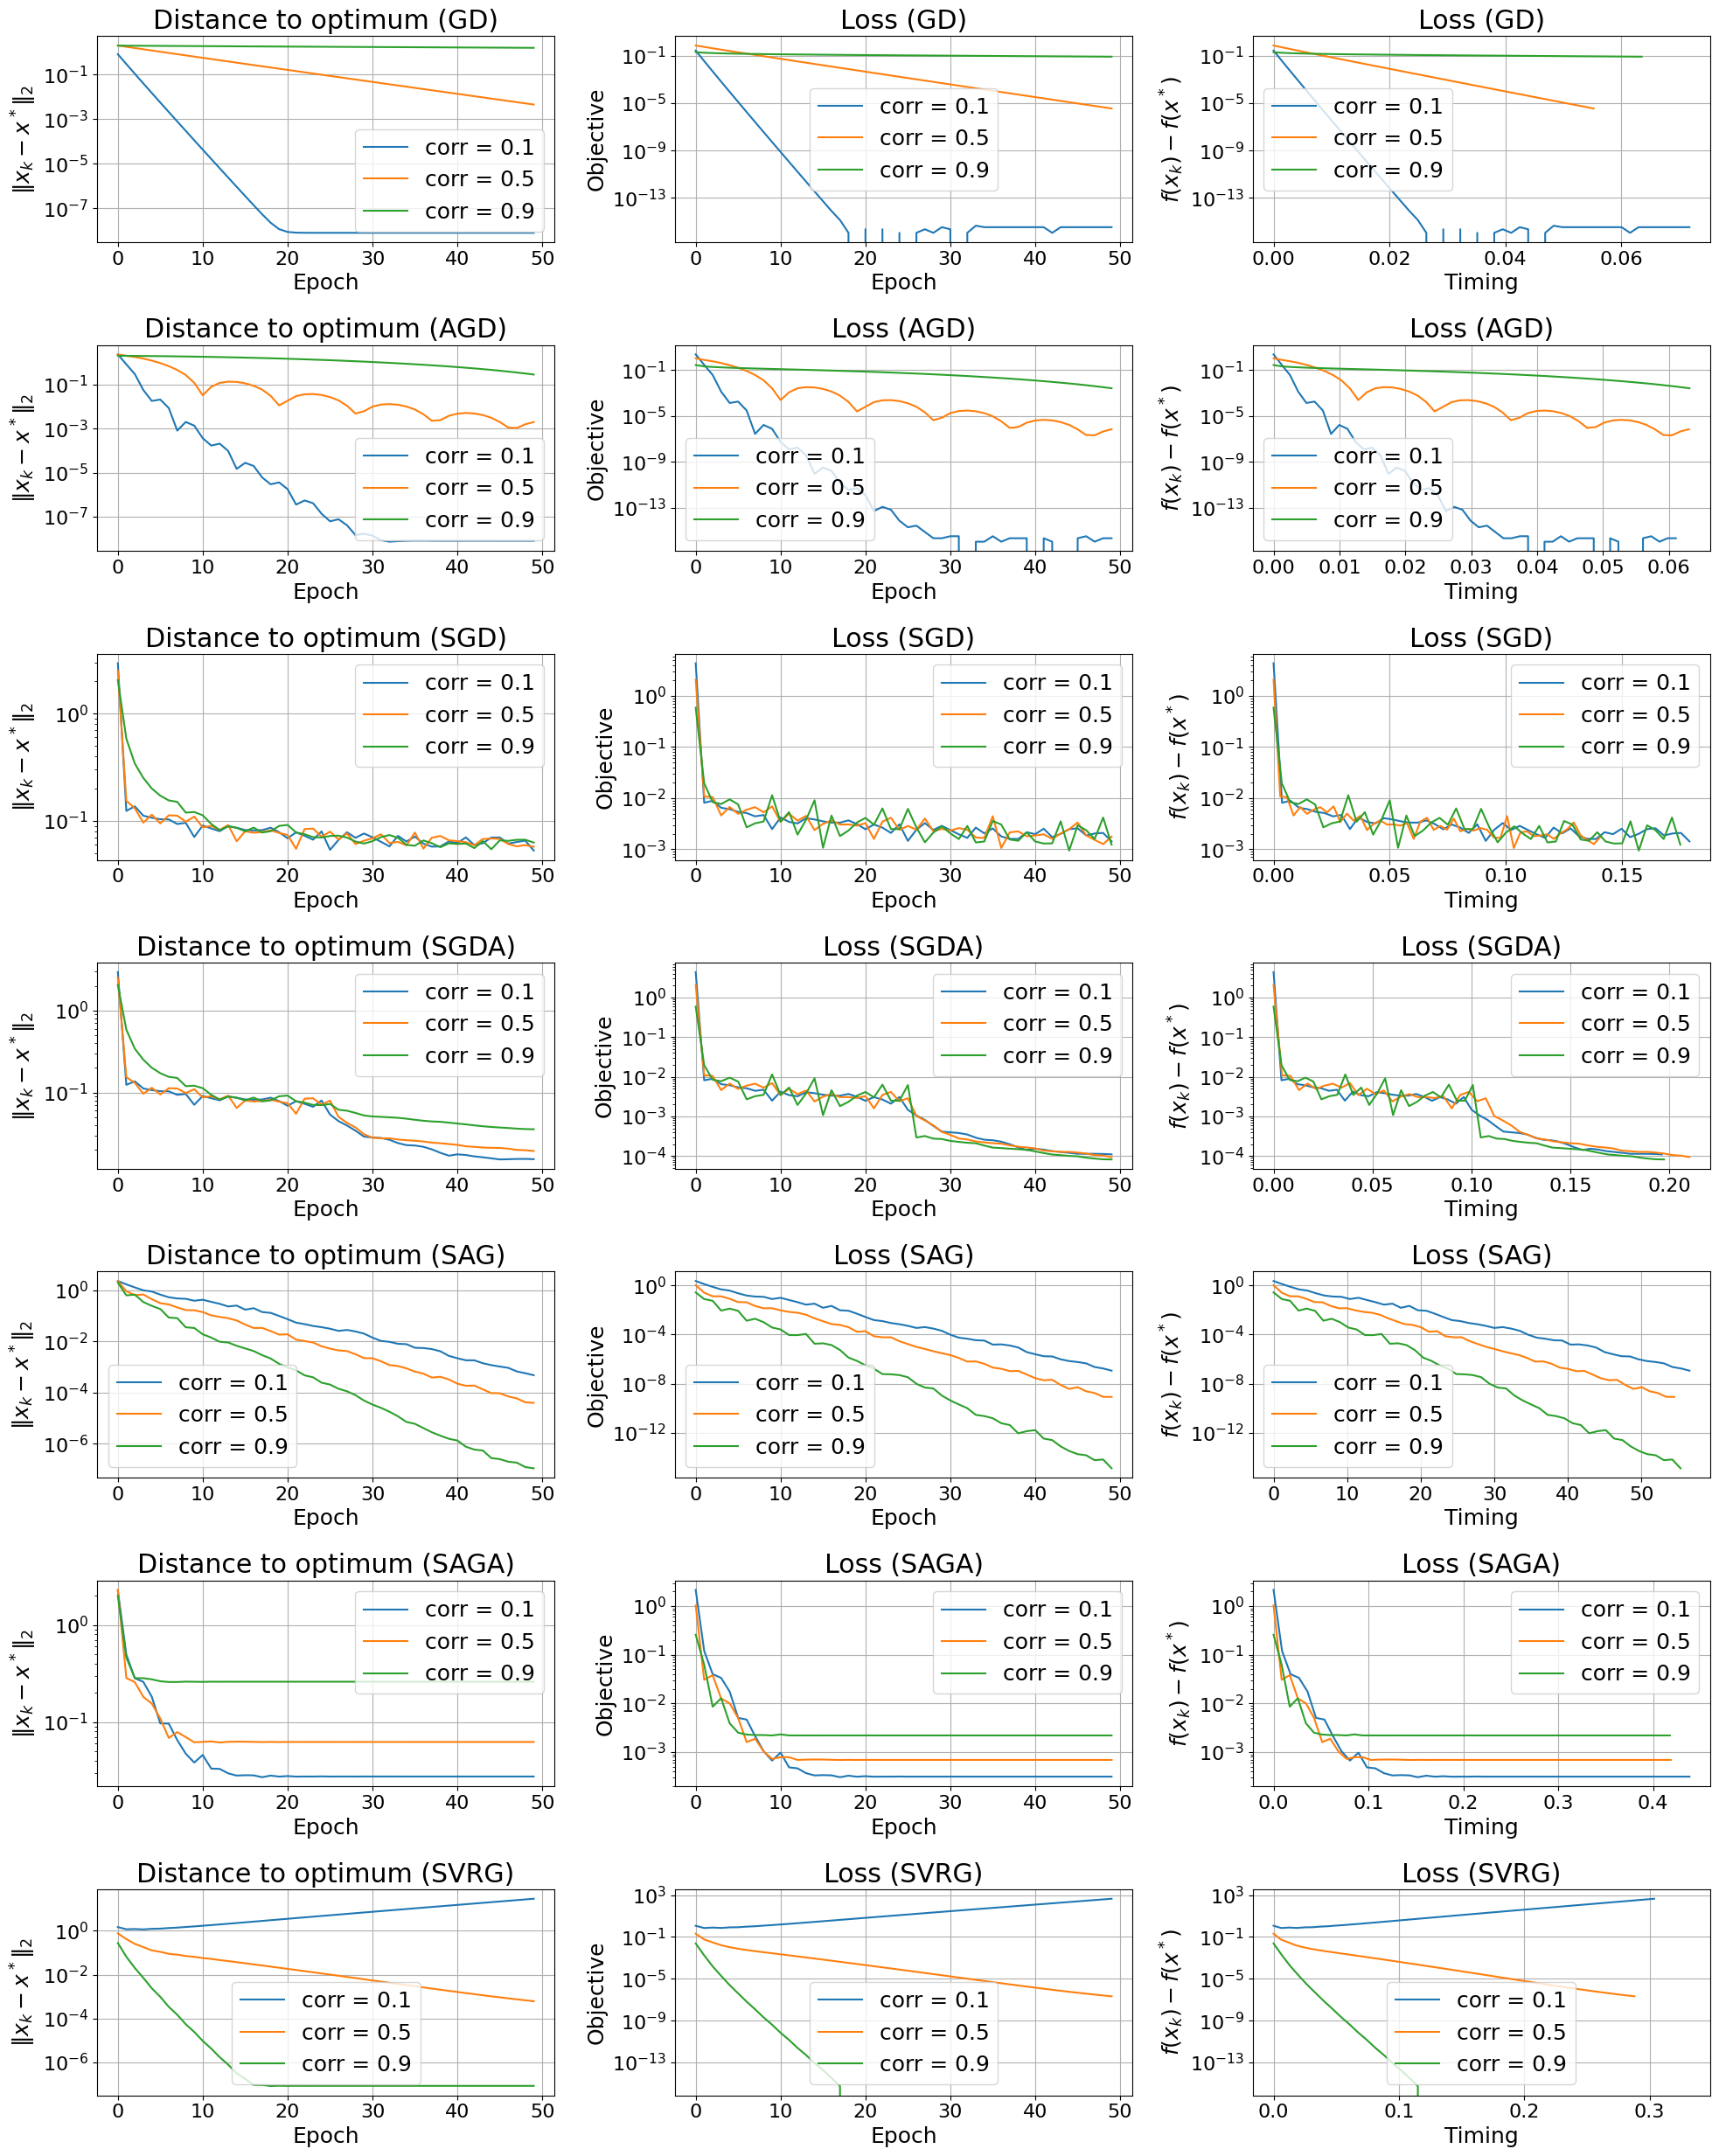

In [77]:
fig, axes = plt.subplots(7, 3, figsize=(20, 25))

# List of the keys of the dictionnary
keys_list = list(dict_algo_string.values())

for i, col_number in enumerate(np.array(monitors_list_corr).squeeze().T):
    for j, monitor_instance in enumerate(col_number):
        # Distance to optimum
        axes[i, 0].semilogy(monitor_instance.err, label=f"corr = {corr_list[j]}")
        # Loss
        axes[i, 1].semilogy(monitor_instance.obj, label=f"corr = {corr_list[j]}")
        # Timing
        axes[i, 2].semilogy(np.linspace(0, monitor_instance.total_time, len(monitor_instance.obj)), monitor_instance.obj, label=f"corr = {corr_list[j]}")

    axes[i, 0].set_title(f"Distance to optimum ({keys_list[i]})")
    axes[i, 0].set_xlabel("Epoch")
    axes[i, 0].set_ylabel("$\|x_k - x^*\|_2$")
    axes[i, 0].legend()
    axes[i, 0].grid()

    axes[i, 1].set_title(f"Loss ({keys_list[i]})")
    axes[i, 1].set_xlabel("Epoch")
    axes[i, 1].set_ylabel("Objective")
    axes[i, 1].legend()
    axes[i, 1].grid()

    axes[i, 2].set_title(f"Loss ({keys_list[i]})")
    axes[i, 2].set_xlabel("Timing")
    axes[i, 2].set_ylabel("$f(x_k) - f(x^*)$")
    axes[i, 2].legend()
    axes[i, 2].grid()

plt.tight_layout()
plt.show()

Q3/

### **Question 4: Conclusion**

----

**Personal conclusion**: